Ref: 
    https://www.kaggle.com/code/hrhuynguyen/s24ep1-binary-classification-w-voting-classifier
        

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import optuna
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

./[Feature][Model] Bank Churn Dataset Prediction.ipynb
./test.csv
./train.csv
./submission1_proto_rf.csv
./sample_submission.csv
./.ipynb_checkpoints/[Feature][Model] Bank Churn Dataset Prediction-checkpoint.ipynb
./catboost_info/learn_error.tsv
./catboost_info/time_left.tsv
./catboost_info/catboost_training.json
./catboost_info/learn/events.out.tfevents


In [4]:
df_train = pd.read_csv("./train.csv")
pd.set_option('display.max_columns', None)
df_train.head(30)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


## Dealing with NaN value

In [5]:
feature_df = df_train.drop(["id","CustomerId","Surname","Exited"],axis=1)
print("The NaN value of feature_df:"+"\n"+str(feature_df.isnull().sum()))

The NaN value of feature_df:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


The result shows that there is not any NaN values in the tabular dataset. Good!

###  Build a Prototype Model0: RandomForestClassfier, without any feature engineering, to make the 1st submission

In [16]:
X0 = pd.get_dummies(feature_df)
y0 = df_train.Exited
X0_train, X0_valid, y0_train, y0_valid = train_test_split(X0, y0,test_size=0.2,random_state=2)
X0.Tenure.unique()

array([ 3,  1, 10,  2,  5,  4,  8,  6,  9,  7,  0])

In [17]:
proto_rf = RandomForestClassifier(n_estimators=100
                                 ,random_state=0
                                ,n_jobs=5)
proto_rf.fit(X0_train,y0_train)


RandomForestClassifier(n_jobs=5, random_state=0)

In [18]:
pred_rf = proto_rf.predict(X0_valid)
pred_rf

array([1, 0, 1, ..., 0, 0, 0])

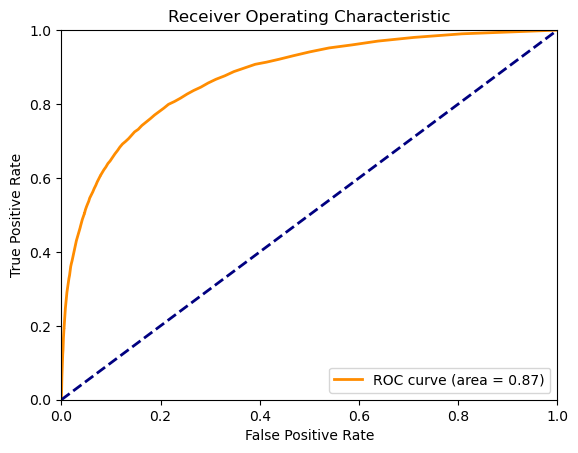

In [19]:
probabilities = proto_rf.predict_proba(X0_valid)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y0_valid, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
to_test = pd.read_csv("./test.csv")
to_test = pd.get_dummies(to_test.drop(["id","CustomerId","Surname"],axis=1))
to_test
rf_res_submission = proto_rf.predict(to_test)
_ = pd.DataFrame({"id":range(165034,275057),"Exited":rf_res_submission})
_.to_csv("submission1_proto_rf.csv",index=False)

In [21]:
## pd.read_csv("./sample_submission.csv",index=False)

This is a submission of public ranking score: 0.73559, ranked (2866/3162). It ranked low. So more discovery should be made.

## EDA
In this part, I used all the features might be related to the churn result, which means the "id","surname" and "Exited" columns are excluded. 

I will do the EDA with the following procedures:
1. **Get an overview of binary target "Exited" first.**
2. **The data into numerical columns and categorial columns. Draw some visualization plot to all their relations between them.**
3. **Select important features that fit the training.**

### 1. Overview of `Exited`

The proportion of those who exited are: 0.212.


([<matplotlib.patches.Wedge at 0x11f692e60>,
 [Text(-0.865773189278974, 0.6785549238828895, 'Not-Exited'),
  Text(0.8657732210444218, -0.6785548833531204, 'Exited')],
 [Text(-0.47223992142489485, 0.3701208675724852, '78.8%'),
  Text(0.4722399387515027, -0.3701208454653384, '21.2%')])

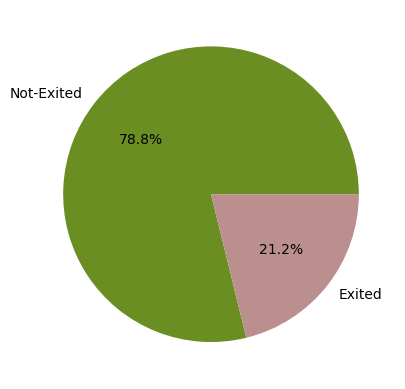

In [22]:
## What is the distribution of Exit?
exited_proportion = df_train.loc[:,"Exited"].sum()/df_train.loc[:,"Exited"].count()
print(f"The proportion of those who exited are: {exited_proportion:.3f}.")
### Draw a pie plot to see a better presentation 
exited_distribution = df_train.Exited.value_counts(normalize=True)
exited_distribution
fig, ax = plt.subplots()
ax.pie(exited_distribution, labels=["Not-Exited","Exited"],
       colors=['olivedrab', 'rosybrown']
      ,autopct='%1.1f%%')

### 2. Analyze Categorial Data and Numerical Data

In [23]:
# Important features that may linked with exited
## Get all datatypes 
print(f"All data types included in this dataset: {set(df_train.dtypes)}\n")
## delete unwanted columns
train = df_train.drop(["id","CustomerId","Surname"],axis=1)
cat_cols = train.select_dtypes(include=["object"]).columns.tolist()
print(f"Categorial columns are: {cat_cols}\n")
num_cols = train.select_dtypes(include=["float64","int64"]).columns.tolist()
print(f"Numerical columns are: {num_cols}")

All data types included in this dataset: {dtype('int64'), dtype('O'), dtype('float64')}

Categorial columns are: ['Geography', 'Gender']

Numerical columns are: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


Automation helps classify data fast. But, the contexts of data shows that `HasCrCard`, `IsActiveMember`, `NumOfProducts` in effect are also categorical values. Therefore we should rewrite the code: 

In [24]:
cat_cols = ["Geography", "Gender", "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember"]
num_cols = ["CreditScore","Age","Balance","EstimatedSalary"]

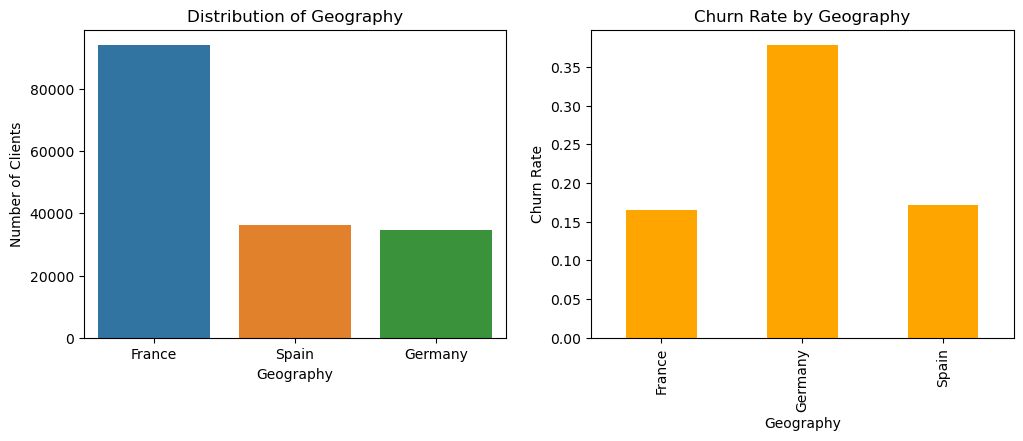

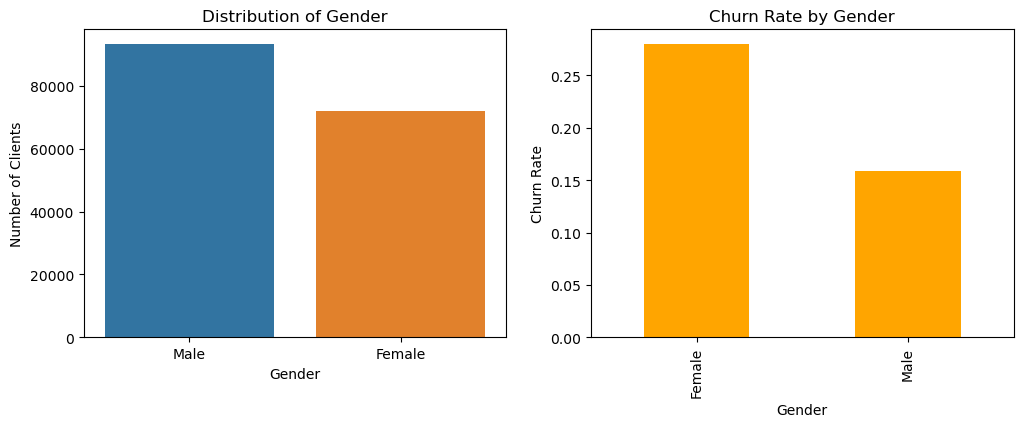

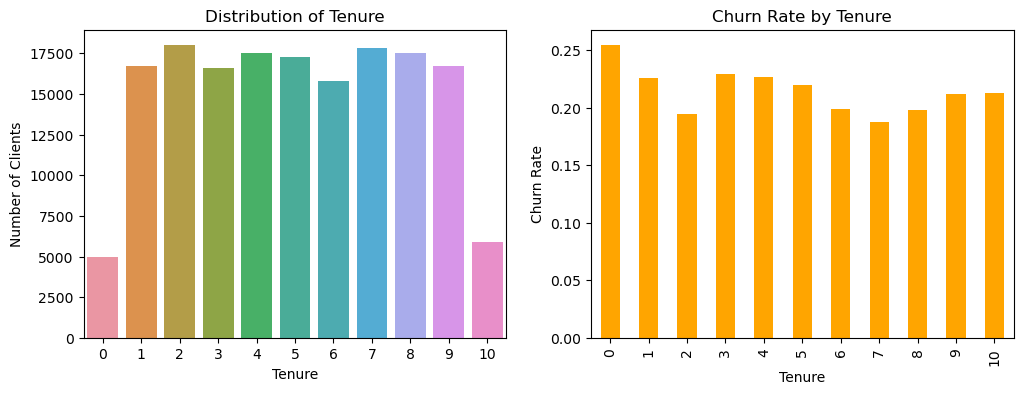

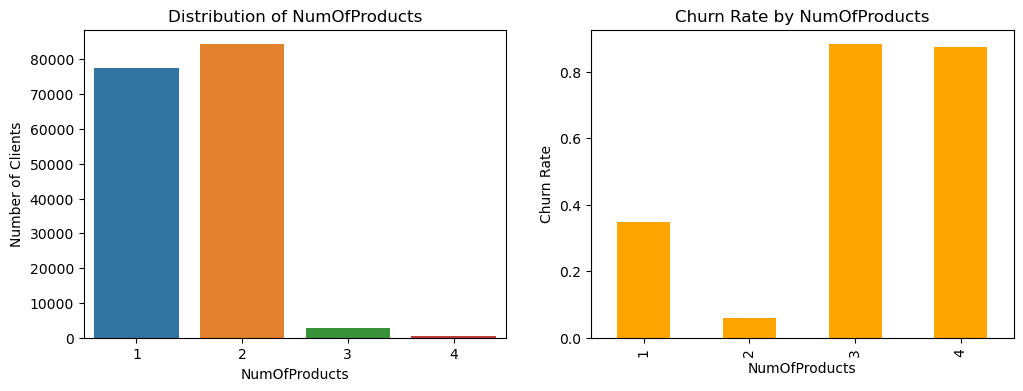

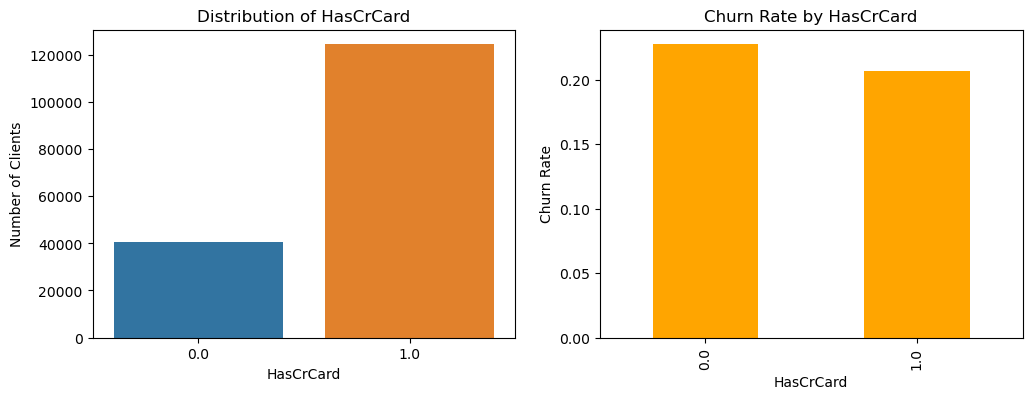

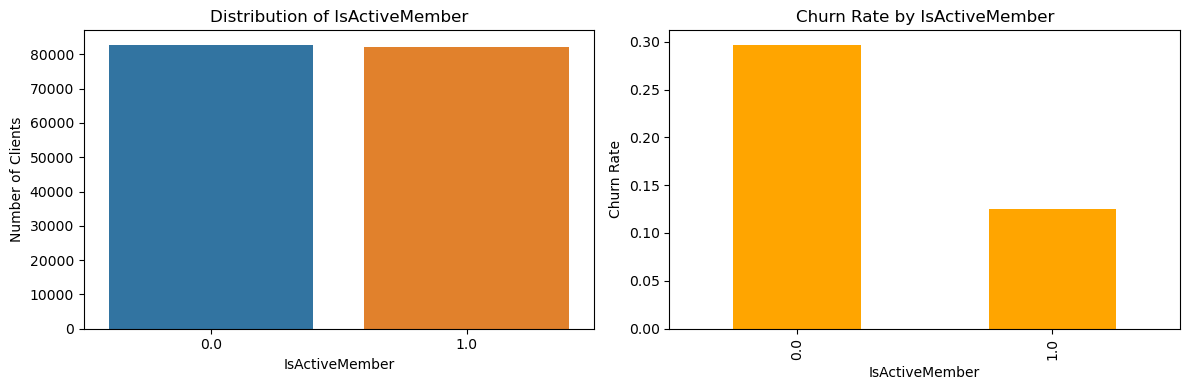

,Distribution,Churn Rate
France,0.570882,0.165282
Germany,0.209690,0.378952
Spain,0.219428,0.172176


In [25]:
## Analyze categorical Columns
cat_plots = []
for cat in cat_cols:
    distribution = train.value_counts(normalize=True)
    
    #Relationship between each category and the churn rate
    
    churn_rate = train.groupby(cat)["Exited"].mean()
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    
    # Plot for distribution 
    sns.countplot(x=cat, data=train, ax = axes[0])
    axes[0].set_title(f"Distribution of {cat}")
    axes[0].set_ylabel("Number of Clients")
    
    # Plot for churn rate
    churn_rate.plot(kind="bar",ax=axes[1],color="orange")
    axes[1].set_title(f"Churn Rate by {cat}")
    axes[1].set_ylabel(f"Churn Rate")
    
    cat_plots.append(fig)
    
plt.tight_layout()
plt.show()

## See one example distribution and churn rate: 
example_feature = cat_cols[0]
example_distribution = train[example_feature].value_counts(normalize=True)
example_churn_rate = train.groupby(example_feature)["Exited"].mean()
example_df = pd.DataFrame({"Distribution":example_distribution,
                          "Churn Rate":example_churn_rate})
example_df

**Basic conclusions from categorial data exploration**
1. `Geography`: Higher Churn Rate(CR) for Germany
2. `Gender`: Higher CR for Female
3. `HasCrCard`: Near the Same... And nearly 75% of clinets have CrCard
4. `IsActiveMember`: Higher CR for non-active member
5. `NumberOfProducts`: Most clients have 1-2 products, few of them has 3-4 products. However, having more products seems to be related to a higher CR rate. 
6. `Tenure`: It seems that there is no discovery.

**Questions Left**
1. What is product?
2. What is tenure? 

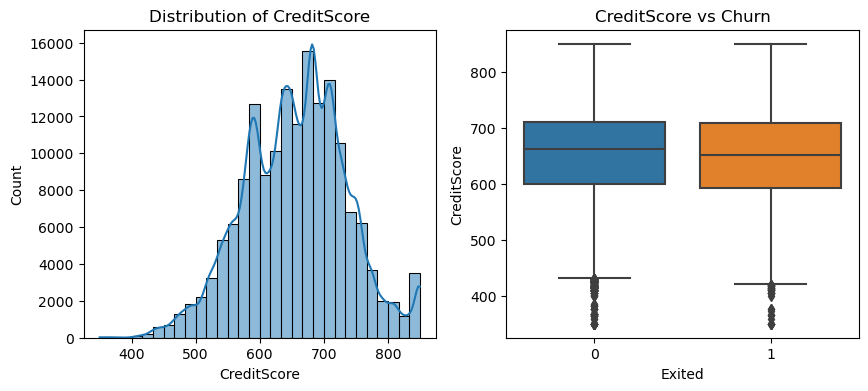

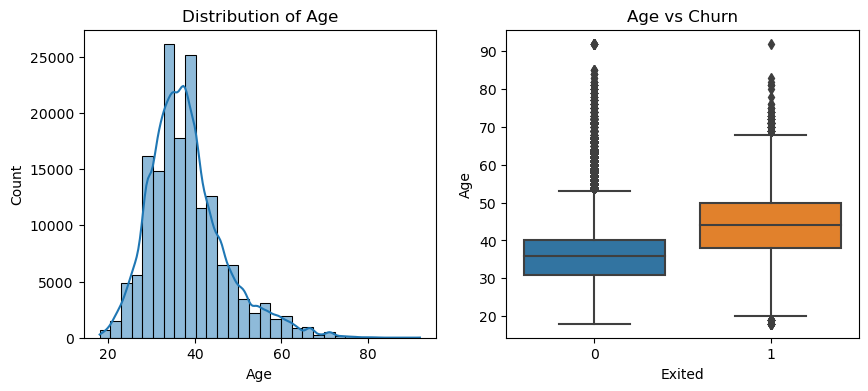

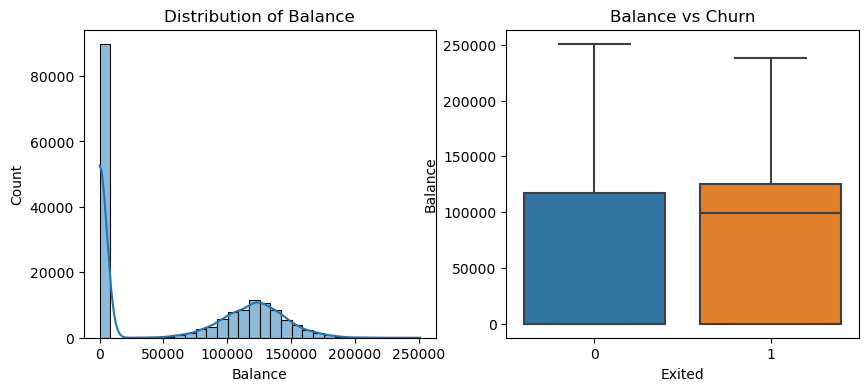

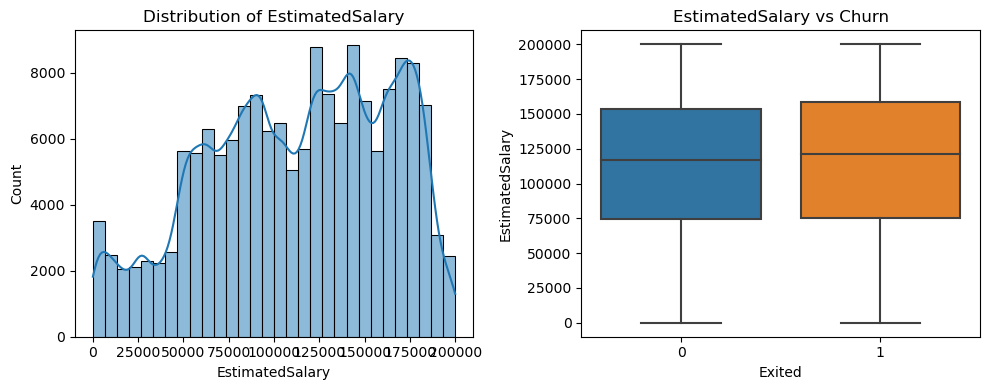

In [26]:
## Analyze numerical datas
num_plots = []

for num_col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    #Distribution plot
    sns.histplot(train[num_col], bins=30, ax=axes[0], kde=True)
    axes[0].set_title(f'Distribution of {num_col}')

    #Boxplot
    sns.boxplot(x='Exited', y=num_col, data=train, ax=axes[1])
    axes[1].set_title(f'{num_col} vs Churn')
    num_plots.append(fig)

plt.tight_layout()
plt.show()

**Conclusion from numerical features**
1. `CreditScore`: CreditScore is basically normally distributed. With the medium number of approxitately 600-700. Comparing from those not-exited and exited. There is not much differences. 
2. `Balance`: It has a peak in no-balance groups, the clients having non-zero balance follows a beautiful normal distribution. 
3. `EstimatedSalary`: The salary distribution is fairly uniform across the range, with no apparent skew. And there seems to be no significant difference in salary distribution between customers who churned and those who did not.
4. `Age`: The distribution pattern of age seems to have a right-skew pattern, with the mean value approximately to 30-40. This distribution shows the bank has more young customers. Those who are older seems more easily to exit. 

### 3. Feature Engeneering
**1. Encoding the Cat variables**

Note: Here I used `OneHotEncoder` instead of `pd.get_dummies()` to do one-hot encoding to my dataset. That is because: 
OneHotEncoder could be able to make the testing dataset transformed in the same form. See:https://albertum.medium.com/preprocessing-onehotencoder-vs-pandas-get-dummies-3de1f3d77dcc

`encoder = OneHotEncoder(drop='first')`, here the parameters drops the first binary column for each categorical feature. For instance, a feature having three values {A,B,C}, this parameter set helps to eliminate C, if A and B are 0, it still represents C is 1. 


In [27]:
def encode_categorical_columns(df, cat_cols):
    # Initialize the one-hot-encoder
    encoder = OneHotEncoder(drop='first')
    # Perform one-hot encoding
    encoding_columns = encoder.fit_transform(df[cat_cols]).toarray()
    encoded_feature_names = []
    for col, categories in zip(cat_cols,encoder.categories_):
        for category in categories[1:]:
            encoded_feature_names.append(f"{col}_{category}")
            
    # Create a DataFrame
    encoded_columns_df = pd.DataFrame(encoding_columns,columns=encoded_feature_names)
    # Conbine the encoded columns
    encoded_df = pd.concat([df,encoded_columns_df],axis=1)
    # Drop the origninal categorical columns
    encoded_df.drop(cat_cols,axis=1,inplace=True)
    
    return encoded_df
    

In [28]:
def encode_categorical_columns(df, categorical_columns):
    #Initialize the OneHotEncoder
    encoder = OneHotEncoder(drop='first')
    #Perform one-hot encoding
    encoded_columns = encoder.fit_transform(df[categorical_columns]).toarray()
    encoded_feature_names = []
    for col, categories in zip(categorical_columns, encoder.categories_):
        for category in categories[1:]: 
            encoded_feature_names.append(f"{col}_{category}")

    #Create a DataFrame
    encoded_columns_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names)
    #Combine the encoded columns
    encoded_df = pd.concat([df, encoded_columns_df], axis=1)
    #Drop the original categorical columns
    encoded_df.drop(categorical_columns, axis=1, inplace=True)

    return encoded_df

In [29]:
# test
train = encode_categorical_columns(train, ['Geography', 'Gender'])
test = pd.read_csv("./test.csv")
test = encode_categorical_columns(test, ['Geography', 'Gender'])



In [30]:
train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.0,0.0,1.0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.0,0.0,1.0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.0,0.0,1.0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.0,0.0,1.0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,0.0,1.0,0.0
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0.0,0.0,1.0
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0.0,0.0,1.0
165032,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0.0,1.0,0.0


## Choose Model
**1. Voting Classifer**
****
In the context of bank churn prediction, where the goal is to identify customers likely to leave, a voting classifier is particularly advantageous due to the multifaceted nature of customer behaviors and the complex patterns within **financial data**. The diversity of reasons behind customer churn—ranging from service dissatisfaction to competitive offers—makes it challenging for a single model to capture all underlying patterns effectively. 
****
A voting classifier, by aggregating predictions from various models, can leverage their individual strengths, thereby offering a more nuanced understanding of customer behaviors. This ensemble approach also helps in handling the typical data imbalances seen in churn datasets, where active customers vastly outnumber those who leave, and ensures robustness against overfitting by averaging out individual model biases. Furthermore, the combination of models facilitates adaptability to changing market conditions and regulatory environments, maintaining predictive performance even as underlying data distributions shift. 
****
Given these benefits, a voting classifier stands out as a strategic choice for banks aiming to enhance their customer retention strategies through accurate and reliable churn predictions.
****
**2. Gradient Boosting Machines(GBM)**
****
* **XGBoost**: Known for its <u>speed and performance</u>, XGBoost is highly efficient for large datasets and can handle missing data, making it a popular choice for churn prediction.
****
* **LightGBM**: Optimized for <u>speed and memory usage</u>, LightGBM is effective for large datasets and can deal with categorical features, often encountered in churn datasets.
****
* **CatBoost**: Particularly <u>good with categorical variables without the need for extensive preprocessing</u>, CatBoost can improve churn prediction accuracy.
****

**3. Deep Learning Model**

* **Fully Connected Neural Networks (FCNN)**: With their ability to learn complex non-linear relationships, FCNNs can be tailored to churn prediction by adjusting the architecture based on the dataset's complexity.

### Hyperparameter Tuning
**1. Splitting the Data**

In [31]:
# Splitting the data into features (X) and the target variables(y)
X = train.drop("Exited", axis=1)
y = train["Exited"]
# Splitting the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3,random_state=1234)

**2.Key Hyperparamaters**

**Bayesian Optimization**

**a.XGBoost**
* **max_depth**: Maximum tree depth.
* **learning_rate**: Step size shrinkage used to prevent overfitting.
* **n_estimators**: Number of gradient boosted trees.
* **subsample**: Subsample ratio of the training instances.
* **colsample_bytree**: Subsample ratio of columns when constructing each tree.



In [61]:
#Function for xgbboost
def xgb_bo(max_depth, learning_rate, n_estimators, gamma, subsample, colsample_bytree):
    params = {
         'max_depth': int(max_depth),
         'learning_rate': learning_rate,
         'n_estimators': int(n_estimators),
         'gamma': gamma,
         'subsample': subsample,
         'colsample_bytree': colsample_bytree,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    #Predict and evaluate
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
   
    return accuracy

# #Hyperparameter space
params_xgb = {
     'max_depth': (3, 10),
     'learning_rate': (0.01, 0.3),
     'n_estimators': (100, 1000),
     'gamma': (0, 5),
     'subsample': (0.5, 1),
     'colsample_bytree': (0.5, 1)
 }
# 
# Initialize Bayesian Optimization
xgb_bo = BayesianOptimization(xgb_bo, params_xgb, random_state=111)
xgb_bo.maximize(init_points=10, n_iter=25)
 
xgb_bo.max['params']

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.86      | 0.8061    | 0.8453    | 0.1365    | 8.385     | 365.8     | 0.5746    |
| 2         | 0.8667    | 0.5112    | 2.101     | 0.07922   | 5.364     | 991.6     | 0.6189    |
| 3         | 0.8662    | 0.5406    | 3.348     | 0.1902    | 4.92      | 519.6     | 0.5592    |
| 4         | 0.8663    | 0.537     | 4.504     | 0.2402    | 8.884     | 833.7     | 0.9955    |
| 5         | 0.8663    | 0.7886    | 4.069     | 0.1322    | 3.192     | 508.7     | 0.5527    |
| 6         | 0.8665    | 0.9086    | 3.489     | 0.1739    | 4.92      | 998.6     | 0.569     |
| 7         | 0.865     | 0.8077    | 2.425     | 0.1275    | 8.095     | 390.5     | 0.7003    |
| 8         | 0.8658    | 0.6595    | 4.736     | 0.2764    | 8.697     | 130.7     | 0.9717    |
| 9         | 0.8654

{'colsample_bytree': 0.5689094125912442,
 'gamma': 2.546524116721165,
 'learning_rate': 0.023291470494861757,
 'max_depth': 6.424649382610974,
 'n_estimators': 991.6497935049412,
 'subsample': 0.6033404874637325}

In [63]:
def dict_to_df(dic,key_col,value_col):
    keys = []
    values = []
    for k,v in dic.items():
        keys.append(k)
        values.append(v)
    
    df = pd.DataFrame({str(key_col):keys,str(value_col):values})
    return df
xgb_df = dict_to_df(xgb_bo.max['params'],"paramaters","Optimal Value")
xgb_df

,paramaters,Optimal Value
0,colsample_bytree,0.568909
1,gamma,2.546524
2,learning_rate,0.023291
3,max_depth,6.424649
4,n_estimators,991.649794
5,subsample,0.603340


**b. LightGBM**

* `num_leaves`: Maximum number of leaves in one tree.
* `learning_rate`: Step size shrinkage.
* `n_estimators`: Number of boosted trees to fit.
* `max_depth`: Maximum tree depth.
* `bagging_fraction`: Specifies the fraction of data to be used for each iteration.

In [65]:
# ligthgbm object function
def lgb_bo(num_leaves,max_depth,learning_rate, n_estimators,min_child_weight,colsample_bytree,subsample, reg_alpha, reg_lambda):
    params = {
        "num_leaves": int(num_leaves),
         'max_depth': int(max_depth),
         'learning_rate': learning_rate,
         'n_estimators': int(n_estimators),
         'min_child_weight': min_child_weight,
         'colsample_bytree': colsample_bytree,
         'subsample': subsample,
         'reg_alpha': reg_alpha,
         'reg_lambda': reg_lambda,
         'objective':'binary',
         'metric': 'binary_logloss',
         'verbosity': -1,
         'boosting_type': 'gbdt',
         'random_state': 111
    }
    
    #Train the model
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train,y_train)
    
    #Predict and evaluate
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val,preds)
    
    return accuracy

#Hyperparameter space
params_lgb = {
     'num_leaves': (30, 80),
     'max_depth': (5, 30),
     'learning_rate': (0.01, 0.3),
     'n_estimators': (100, 1000),
     'min_child_weight': (0.001, 0.1),
     'colsample_bytree': (0.4, 1.0),
     'subsample': (0.4, 1.0),
     'reg_alpha': (0, 1),
     'reg_lambda': (0, 1)
 }

#Bayesian Optimization
lgb_bo = BayesianOptimization(lgb_bo, params_lgb, random_state=111)

lgb_bo.maximize(init_points=10, n_iter=25)

lgb_bo.max['params']

df_lightgbm = dict_to_df(lgb_bo.max['params'],"paramaters","Optimal Value")

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8672    | 0.7673    | 0.05903   | 15.9      | 0.07716   | 365.8     | 37.46     | 0.02248   | 0.4202    | 0.5432    |
| 2         | 0.8548    | 0.6026    | 0.2973    | 10.94     | 0.009038  | 702.6     | 61.06     | 0.2743    | 0.4662    | 0.471     |
| 3         | 0.8557    | 0.4444    | 0.2712    | 24.85     | 0.08422   | 833.7     | 79.55     | 0.5773    | 0.8138    | 0.6528    |
| 4         | 0.863     | 0.4165    | 0.1417    | 7.633     | 0.0819    | 728.0     | 58.26     | 0.2742    | 0.9985    | 0.4828    |
| 5         | 0.865     | 0.7692    | 0.1507    | 15.13     | 0.07306   | 390.5     | 50.03     | 0.319     | 0.9472    | 0.9512    |
| 6         | 0.8671    | 0.8883    | 0.01988   | 28.58     | 

,paramaters,Optimal Value
0,colsample_bytree,0.767302
1,learning_rate,0.059030
2,max_depth,15.901475
3,min_child_weight,0.077157
4,n_estimators,365.792774
5,num_leaves,37.458148
6,reg_alpha,0.022478
7,reg_lambda,0.420224
8,subsample,0.543209


In [73]:
lgb_bo.max['params']

{'colsample_bytree': 0.7673021053705712,
 'learning_rate': 0.05903022876023456,
 'max_depth': 15.901475484279255,
 'min_child_weight': 0.07715698477978916,
 'n_estimators': 365.79277396258857,
 'num_leaves': 37.45814785697449,
 'reg_alpha': 0.022478324544161765,
 'reg_lambda': 0.4202244922645577,
 'subsample': 0.5432092847478677}

**c. CatBoost**

* **depth**: Depth of the tree.
* **learning_rate**: Learning rate.
* **iterations**: Number of trees to build.
* **l2_leaf_reg**: Coefficient at the L2 regularization term of the cost function.
* **border_count**: Number of splits for numerical features.

In [66]:
# Catboost objective function 
def catboost_bo(depth, learning_rate, iterations, l2_leaf_reg, border_count, scale_pos_weight, bagging_temperature):
    params = {
       'depth': int(depth),
         'learning_rate': learning_rate,
         'iterations': int(iterations),
         'l2_leaf_reg': l2_leaf_reg,
         'border_count': int(border_count),
         'scale_pos_weight': scale_pos_weight,
         'bagging_temperature': bagging_temperature,
         'loss_function': 'Logloss',
         'verbose': False,
         'random_seed': 111
     }
     #Train
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
  
     #Predict and evaluate
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
  
    return accuracy
# 
# Hyperparmeter 
params_catboost = {
     'depth': (4, 10),
     'learning_rate': (0.01, 0.3),
     'iterations': (100, 800),
     'l2_leaf_reg': (1, 10),
     'border_count': (5, 255),
     'scale_pos_weight': (0.01, 1.0),
     'bagging_temperature': (0.0, 1.0)
 }
 
 #Bayesian Optimization
catboost_bo = BayesianOptimization(catboost_bo, params_catboost, random_state=111)
catboost_bo.maximize(init_points=10, n_iter=25)

df_catboost = dict_to_df(catboost_bo.max['params'],"paramaters","Optimal Value")
df_catboost


|   iter    |  target   | baggin... | border... |   depth   | iterat... | l2_lea... | learni... | scale_... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7994    | 0.6122    | 47.27     | 6.616     | 638.5     | 3.658     | 0.05326   | 0.03225   |
| 2         | 0.8635    | 0.4202    | 64.67     | 6.026     | 793.5     | 3.14      | 0.03355   | 0.6729    |
| 3         | 0.8656    | 0.6212    | 73.56     | 6.797     | 182.9     | 1.666     | 0.2712    | 0.796     |
| 4         | 0.8113    | 0.8406    | 208.8     | 9.946     | 504.1     | 8.324     | 0.1322    | 0.03717   |
| 5         | 0.8651    | 0.4541    | 31.33     | 8.903     | 588.4     | 6.088     | 0.08953   | 0.9985    |
| 6         | 0.854     | 0.138     | 158.9     | 6.91      | 383.5     | 7.551     | 0.1036    | 0.4065    |
| 7         | 0.8541    | 0.319     | 241.8     | 9.512     | 669.7     | 1.307     | 0.2836    | 0.9509    |
| 8       

In [70]:
def fcnn_bo(neurons, dropout_rate, learning_rate, batch_size, epochs):
    #Model building
    model = Sequential([
    Dense(int(neurons), input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])
    
    #Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
     
#Training
    model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size), verbose=0)
     
    #Evaluation
    preds = model.predict(X_val)
    preds = np.round(preds)
    accuracy = accuracy_score(y_val, preds)
  
    return accuracy

#Hyperparameter Space
params_fcnn = {
     'neurons': (10, 200),  # Number of neurons in the hidden layer
     'dropout_rate': (0.1, 0.5),  # Dropout rate to prevent overfitting
     'learning_rate': (0.001, 0.01),  # Learning rate for the optimizer
     'batch_size': (32, 128),  # Batch size for training
     'epochs': (10, 50)  # Number of epochs for training
 }
 
#Initialize Bayesian Optimization
fcnn_bo = BayesianOptimization(fcnn_bo, params_fcnn, random_state=111)
fcnn_bo.maximize(init_points=10, n_iter=15)
 


fcnn_df = dict_to_df(fcnn_bo.max['params'],"Parameters","Optimal Values")

|   iter    |  target   | batch_... | dropou... |  epochs   | learni... |  neurons  |
-------------------------------------------------------------------------------------
1548/1548 [==============================] - 1s 351us/step


| 1         | 0.7875    | 90.77     | 0.1676    | 27.44     | 0.007923  | 66.11     |
1548/1548 [==============================] - 1s 368us/step


| 2         | 0.7875    | 46.32     | 0.109     | 26.81     | 0.003148  | 74.15     |
1548/1548 [==============================] - 1s 389us/step


| 3         | 0.7875    | 127.1     | 0.1951    | 13.25     | 0.007026  | 128.0     |
1548/1548 [==============================] - 1s 469us/step


| 4         | 0.7875    | 58.33     | 0.2865    | 14.73     | 0.001666  | 181.1     |
1548/1548 [==============================] - 1s 393us/step


| 5         | 0.7875    | 108.2     | 0.4362    | 42.61     | 0.009919  | 119.7     |
1548/1548 [==============================] - 1s 382us/step


| 6         | 0.7875    | 110.1     | 0.2685    | 11.1      | 0.005087  | 30.01     |
1548/1548 [==============================] - 1s 372us/step


| 7         | 0.7875    | 110.5     | 0.3791    | 32.61     | 0.003468  | 199.7     |
1548/1548 [==============================] - 1s 384us/step


| 8         | 0.7875    | 45.25     | 0.3462    | 29.4      | 0.004645  | 148.3     |
1548/1548 [==============================] - 1s 367us/step


| 9         | 0.7875    | 62.99     | 0.2602    | 22.76     | 0.009525  | 184.6     |
1548/1548 [==============================] - 1s 383us/step


| 10        | 0.7875    | 110.1     | 0.1136    | 47.73     | 0.009554  | 163.3     |
1548/1548 [==============================] - 1s 356us/step


| 11        | 0.7875    | 33.79     | 0.474     | 31.09     | 0.00878   | 86.46     |
1548/1548 [==============================] - 1s 376us/step


| 12        | 0.7875    | 36.77     | 0.1734    | 11.86     | 0.002632  | 155.2     |
1548/1548 [==============================] - 1s 382us/step


| 13        | 0.7875    | 98.69     | 0.2651    | 11.65     | 0.009728  | 187.6     |
1548/1548 [==============================] - 1s 369us/step


| 14        | 0.7875    | 101.0     | 0.2533    | 15.79     | 0.007233  | 143.5     |
1548/1548 [==============================] - 1s 411us/step


| 15        | 0.7875    | 38.63     | 0.1909    | 15.38     | 0.002492  | 94.48     |
1548/1548 [==============================] - 1s 359us/step


| 16        | 0.7875    | 75.61     | 0.4548    | 23.29     | 0.009006  | 144.2     |
1548/1548 [==============================] - 1s 353us/step


| 17        | 0.7875    | 126.7     | 0.142     | 48.46     | 0.005999  | 10.41     |
1548/1548 [==============================] - 1s 358us/step


| 18        | 0.7875    | 32.05     | 0.2137    | 47.12     | 0.001474  | 12.63     |
1548/1548 [==============================] - 1s 389us/step


| 19        | 0.7875    | 114.8     | 0.1052    | 42.68     | 0.004379  | 140.6     |
1548/1548 [==============================] - 1s 367us/step


| 20        | 0.7875    | 92.57     | 0.346     | 10.14     | 0.007905  | 158.7     |
1548/1548 [==============================] - 1s 354us/step


| 21        | 0.7875    | 106.5     | 0.2607    | 28.94     | 0.005644  | 43.86     |
1548/1548 [==============================] - 1s 375us/step


| 22        | 0.7875    | 125.2     | 0.3776    | 10.45     | 0.009652  | 11.52     |
1548/1548 [==============================] - 1s 344us/step


| 23        | 0.7875    | 32.05     | 0.4991    | 47.73     | 0.004859  | 11.15     |
1548/1548 [==============================] - 1s 371us/step


| 24        | 0.7875    | 52.29     | 0.3308    | 14.64     | 0.005097  | 192.6     |
1548/1548 [==============================] - 122s 79ms/step
| 25        | 0.7875    | 124.8     | 0.2736    | 49.66     | 0.006789  | 198.9     |


In [72]:
def rf_bo(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    # Hyperparameters must be cast to integer where necessary
    params = {
         'n_estimators': int(n_estimators),
         'max_depth': None if max_depth is None else int(max_depth),
         'min_samples_split': int(min_samples_split),
         'min_samples_leaf': int(min_samples_leaf),
         'max_features': max_features
     }
     
     # Model training
    rf = RandomForestClassifier(**params, random_state=111)
    rf.fit(X_train, y_train)
     
     # Model evaluation
    preds = rf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
#    
    return accuracy

params_rf = {
     'n_estimators': (100, 1000),
     'max_depth': (10, 100),  # You can include None in the range if you want to consider unlimited depth
     'min_samples_split': (2, 10),
     'min_samples_leaf': (1, 4),
     'max_features': (0.1, 0.999)  # Fraction of features considered for each split
 }
 
 #Bayesian Optimization
rf_bo = BayesianOptimization(rf_bo, params_rf, random_state=111)
rf_bo.maximize(init_points=10, n_iter=25)
 
rf_bo.max['params']
rf_df = dict_to_df(rf_bo.max['params'],"Parameters","Optimal Values")

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.8637    | 65.1      | 0.252     | 2.308     | 8.154     | 365.8     |
| 2         | 0.8614    | 23.42     | 0.1202    | 2.261     | 3.909     | 403.9     |
| 3         | 0.8626    | 99.16     | 0.3137    | 1.244     | 7.357     | 659.1     |
| 4         | 0.8594    | 34.68     | 0.5191    | 1.355     | 2.592     | 910.7     |
| 5         | 0.8615    | 81.46     | 0.8557    | 3.446     | 9.928     | 619.5     |
| 6         | 0.86      | 83.24     | 0.4788    | 1.082     | 5.633     | 194.8     |
| 7         | 0.8602    | 83.55     | 0.7273    | 2.696     | 4.194     | 998.6     |
| 8         | 0.8609    | 22.42     | 0.6533    | 2.455     | 5.24      | 755.1     |
| 9         | 0.8619    | 39.05     | 0.4601    | 1.957     | 9.578     | 926.8     |
| 10        | 0.8617    | 83.25     | 0.1306    | 3.83

### Model Integration and Deployment
In this approach, we will choose a Voting Classifier. It is advantageous due to its ability to combine the strengths of multiple diverse models to improve overall prediction accuracy and robustness. In the context of bank churn, where it's critical to accurately identify customers at risk of leaving, different models may capture various aspects of customer behavior and interactions with banking services. In this case, decision tree-based models like RandomForest, Gradient Boosting Machines (XGBoost, LightGBM), and CatBoost can capture non-linear relationships and interactions between features, while other models might capture different patterns. A Voting Classifier aggregates the predictions from each model, potentially leading to a more balanced and nuanced understanding of factors influencing churn. This ensemble approach reduces the likelihood of overfitting to the training data and increases the generalizability of the predictions to unseen data, making it a strong choice for complex, real-world problems like predicting customer churn in the banking sector.

**1. Initialize individual models**

In [77]:
xgb_params = {"colsample_bytree":0.568909
            ,"gamma":2.546524
            ,"learning_rate":0.023291
            ,"max_depth":int(6.424649)
            ,"n_estimators":int(991.649794)
            ,'subsample':0.603340
             }
xgb_model = XGBClassifier(**xgb_params)

lgbm_params = {"colsample_bytree":0.767302
               ,"learning_rate":0.059030
               ,"max_depth":int(round(15.901475))
               ,"min_child_weight":0.077157
               ,"n_estimators":int(round(365.792774))
               ,"num_leaves":int(37.458148)
               ,"reg_alpha":0.022478
               ,"reg_lambda":0.420224
               ,"subsample":0.543209
}
lgbm_model = LGBMClassifier(**lgbm_params)

#FCNN
fcnn_params = {
    'batch_size': int(round(90.7683368592914)), 
    'dropout_rate': 0.1676279017382546,
    'epochs': int(round(27.442360774846808)), 
    'learning_rate': 0.007923362252708108,
    'neurons': int(round(66.11180783654648)) 
}
fcnn_model = Sequential([
    Dense(fcnn_params['neurons'], activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(fcnn_params['dropout_rate']),
    Dense(fcnn_params['neurons'], activation='relu'),
    Dense(1, activation='sigmoid') 
])
fcnn_model.compile(optimizer=Adam(learning_rate=fcnn_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

#Random Forest
rf_params = {
    'max_depth': int(round(11.046943046504415)),  
    'max_features': 0.49651208769136024,
    'min_samples_leaf': int(round(2.9151918194576902)),  
    'min_samples_split': int(round(6.727579544354182)), 
    'n_estimators': int(467.7983990692384)  
}
rf_model = RandomForestClassifier(**rf_params)

#CatBoost
catboost_params = {
    'bagging_temperature': 0.36370089413125906,
    'border_count': int(round(110.17665074805907)),  
    'depth': int(round(8.80123805330766)),  
    'iterations': int(round(160.95695656931696)),  
    'l2_leaf_reg': 10.0,
    'learning_rate': 0.3,
    'scale_pos_weight': 1.0
}
catboost_model = CatBoostClassifier(**catboost_params)

In [78]:
#XGBoost
xgb_model.fit(X_train, y_train)
#LightGBM
lgbm_model.fit(X_train, y_train)
#CatBoost
catboost_model.fit(X_train, y_train, verbose=0)
#Random Forest
rf_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 24401, number of negative: 91122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 115523, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211222 -> initscore=-1.317575
[LightGBM] [Info] Start training from score -1.317575


RandomForestClassifier(max_depth=11, max_features=0.49651208769136024,
                       min_samples_leaf=3, min_samples_split=7,
                       n_estimators=467)

In [83]:
from sklearn.ensemble import VotingClassifier

# Initial Voting Classifier setup with equal weights
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model),
        ('rf', rf_model)
    ],
    voting='soft',  # Use 'soft' for weight optimization based on probabilities
    weights=[1, 1, 1, 1]  
)

In [85]:
def objective(trial):
    #Assigns weights for each model within the Voting Classifier
    xgb_weight = trial.suggest_float('xgb_weight', 0.1, 3.0)
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.1, 3.0)
    catboost_weight = trial.suggest_float('catboost_weight', 0.1, 3.0)
    rf_weight = trial.suggest_float('rf_weight', 0.1, 3.0)

    #Updates weight
    voting_clf.set_params(weights=[xgb_weight, lgbm_weight, catboost_weight, rf_weight])

    #Evaluate using cross-validation
    score = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

In [2]:
#Optuna study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  

# Output the best set of weights and the corresponding score
best_weights = study.best_params
best_score = study.best_value

print("Best Weights:", best_weights)
print("Best Score:", best_score)

[I 2024-01-31 16:32:45,772] A new study created in memory with name: no-name-2cb97b15-cfc6-4aca-b7c2-8fc7f21ed69a


NameError: name 'objective' is not defined

Get the best weights from the optuna process. Use that for new Voting Classifier training.

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model),
        ('rf', rf_model)
    ],
    voting='soft', 
    weights=[2.691108, 0.522020, 1.647524, 1.769939]  
)

voting_clf.fit(X_train, y_train)
#Predict probabilities for the test data
probabilities = voting_clf.predict_proba(test)
exited = probabilities[:, 1]